In [1]:
import pickle
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
splits = ['random', 'scaffold', 'protein']
datasets = ['pdbbind', 'platinum']
tasks = ['all', 'easy', 'hard']
results_dir = 'results/'
iterations = range(5)

In [3]:
bioactive_accuracy_df = pd.DataFrame()
regression_df = pd.DataFrame()
ranking_df = pd.DataFrame()

In [4]:
for dataset in datasets :
    for split in splits :
        for iteration in iterations :
            for task in tasks :
                dataset_results_path = os.path.join(f'results/{split}_split_{iteration}_molsize_{dataset}/', 
                                                    f'dataset_results_{task}.p')
                if os.path.exists(dataset_results_path) :
                    with open(dataset_results_path, 'rb') as f:
                        dataset_results = pickle.load(f)

                    dataset_results['bioactive_accuracy']['split'] = split
                    dataset_results['bioactive_accuracy']['dataset'] = dataset
                    dataset_results['bioactive_accuracy']['task'] = task
                    bioactive_accuracy_df = bioactive_accuracy_df.append(pd.Series(dataset_results['bioactive_accuracy']), ignore_index=True)

                    for average_type in dataset_results['regression'] :
                        dataset_results['regression'][average_type]['split'] = split
                        dataset_results['regression'][average_type]['dataset'] = dataset
                        dataset_results['regression'][average_type]['task'] = task
                        dataset_results['regression'][average_type]['average_type'] = average_type
                        regression_df = regression_df.append(pd.Series(dataset_results['regression'][average_type]), ignore_index=True)

                    for ranker in dataset_results['ranking'] :
                        dataset_results['ranking'][ranker]['split'] = split
                        dataset_results['ranking'][ranker]['dataset'] = dataset
                        dataset_results['ranking'][ranker]['task'] = task
                        dataset_results['ranking'][ranker]['ranker'] = ranker
                        ranking_df = ranking_df.append(pd.Series(dataset_results['ranking'][ranker]), ignore_index=True)

In [5]:
regression_df['subset'] = regression_df['task']

In [6]:
regression_df

,average_type,dataset,pearson_all,pearson_gen,r2_all,r2_gen,rmse_all,rmse_bio,rmse_gen,spearman_all,spearman_gen,split,task,subset
0,Micro,pdbbind,0.645303,0.664620,0.415814,0.441463,0.754713,1.685748,0.715996,0.611909,0.624984,random,all,all
1,Macro,pdbbind,NaN,NaN,-8.772916,-8.621582,0.677125,1.732632,0.622939,NaN,NaN,random,all,all
2,Micro,pdbbind,0.524054,0.523112,0.215221,0.238674,0.605453,1.038176,0.554780,0.411514,0.387843,random,easy,easy
3,Macro,pdbbind,NaN,NaN,-24.342225,-24.171407,0.587801,1.109371,0.505606,NaN,NaN,random,easy,easy
4,Micro,pdbbind,0.612314,0.637773,0.374825,0.406076,0.772055,2.041631,0.733566,0.576796,0.593936,random,hard,hard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,Macro,platinum,NaN,NaN,-117.667343,-381.491725,0.606027,1.479289,0.567106,NaN,NaN,protein,all,all
176,Micro,platinum,0.398306,0.393256,0.140855,0.140528,0.582507,1.020611,0.553293,0.321206,0.309272,protein,easy,easy
177,Macro,platinum,NaN,NaN,-311.538887,-1048.997633,0.554897,1.020611,0.491144,NaN,NaN,protein,easy,easy
178,Micro,platinum,0.524871,0.542039,0.267803,0.281122,0.678421,1.755757,0.657439,0.506520,0.516701,protein,hard,hard


In [7]:
def r2_results(dataset) :
    ylabel = 'R2'
    new_data = regression_df[(regression_df['dataset'] == dataset) 
                             & (regression_df['average_type'] == 'Micro') 
                             & (regression_df['task'] == 'all')]
    all_data = new_data[['split', 'r2_all']]
    all_data = all_data.rename({'r2_all' : ylabel}, axis=1)
    all_data['Conformation subset'] = 'All'
    gen_data = new_data[['split', 'r2_gen']]
    gen_data = gen_data.rename({'r2_gen' : ylabel}, axis=1)
    gen_data['Conformation subset'] = 'Generated'
    merged_data = pd.concat([all_data, gen_data])

    grouped_data = merged_data.groupby(['Conformation subset', 'split'], sort=False).agg({ylabel : ['mean', 'std']})
    grouped_data.round(2)
    
    return grouped_data

In [8]:
grouped_data = r2_results('pdbbind')
grouped_data.round(2)

R2      
                              mean   std
Conformation subset split               
All                 random    0.41  0.02
                    scaffold  0.36  0.01
                    protein   0.40  0.03
Generated           random    0.44  0.02
                    scaffold  0.38  0.01
                    protein   0.42  0.03

In [9]:
grouped_data = r2_results('platinum')
grouped_data.round(2)

R2      
                              mean   std
Conformation subset split               
All                 random    0.32  0.00
                    scaffold  0.32  0.01
                    protein   0.32  0.00
Generated           random    0.33  0.00
                    scaffold  0.33  0.00
                    protein   0.33  0.00

In [10]:
def rmse_results(dataset) : 
    ylabel = 'Mean RMSE'
    new_data = regression_df[(regression_df['dataset'] == dataset) 
                             & (regression_df['average_type'] == 'Micro') 
                             & (regression_df['task'] == 'all')]
    all_data = new_data[['split', 'rmse_all']]
    all_data = all_data.rename({'rmse_all' : ylabel}, axis=1)
    all_data['Conformation subset'] = 'All'
    gen_data = new_data[['split', 'rmse_gen']]
    gen_data = gen_data.rename({'rmse_gen' : ylabel}, axis=1)
    gen_data['Conformation subset'] = 'Generated'
    bio_data = new_data[['split', 'rmse_bio']]
    bio_data = bio_data.rename({'rmse_bio' : ylabel}, axis=1)
    bio_data['Conformation subset'] = 'Bioactive'
    merged_data = pd.concat([all_data, gen_data, bio_data])

    grouped_data = merged_data.groupby(['Conformation subset', 'split'], sort=False).agg({ylabel : ['mean', 'std']})
    return grouped_data

In [11]:
grouped_data = rmse_results('pdbbind')
grouped_data.round(2)

Mean RMSE      
                                  mean   std
Conformation subset split                   
All                 random        0.75  0.01
                    scaffold      0.75  0.01
                    protein       0.74  0.03
Generated           random        0.71  0.01
                    scaffold      0.72  0.02
                    protein       0.71  0.02
Bioactive           random        1.67  0.03
                    scaffold      1.77  0.10
                    protein       1.68  0.09

In [12]:
grouped_data = rmse_results('platinum')
grouped_data.round(2)

Mean RMSE      
                                  mean   std
Conformation subset split                   
All                 random        0.67  0.00
                    scaffold      0.67  0.00
                    protein       0.67  0.00
Generated           random        0.64  0.00
                    scaffold      0.64  0.00
                    protein       0.64  0.00
Bioactive           random        1.56  0.03
                    scaffold      1.56  0.04
                    protein       1.54  0.04

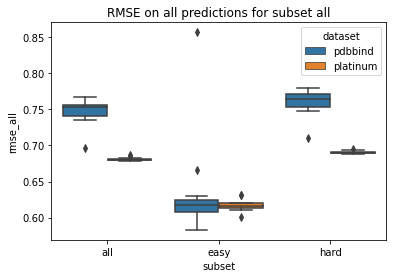

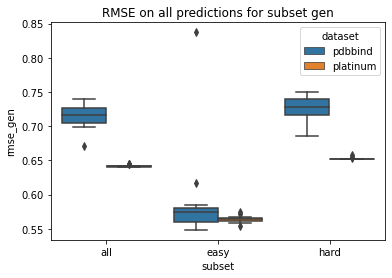

In [14]:
data = regression_df[(regression_df['average_type'] == 'Micro')]
for subset in ['all', 'gen'] :
    sns.boxplot(data=data, x='subset', y=f'rmse_{subset}', hue='dataset')
    plt.title(f'RMSE on all predictions for subset {subset}')
    plt.savefig(f'figures/rmse_{subset}.png', dpi=200)
    plt.show()

In [17]:
bioactive_accuracy_df['subset'] = bioactive_accuracy_df['task']

In [18]:
bioactive_accuracy_df.head()

,dataset,mean_top1_accuracy,mean_topN_accuracy,median_all_bioactive,median_min_bioactive,median_normalized_bioactive,q1_all_bioactive,q1_min_bioactive,q1_normalized_bioactive,q3_all_bioactive,q3_min_bioactive,q3_normalized_bioactive,split,task,subset
0,pdbbind,0.0,0.011976,75.0,100.0,0.990099,26.0,27.0,0.833333,100.0,100.0,0.990099,random,all,all
1,pdbbind,0.0,0.036112,10.5,12.0,0.904545,4.0,4.0,0.666667,31.0,36.0,0.971429,random,easy,easy
2,pdbbind,0.0,0.000000,100.0,100.0,0.990099,75.0,100.0,0.990099,100.0,100.0,0.990099,random,hard,hard
3,platinum,0.0,0.011976,75.0,100.0,0.990099,26.0,27.0,0.833333,100.0,100.0,0.990099,random,all,all
4,platinum,0.0,0.036112,10.5,12.0,0.904545,4.0,4.0,0.666667,31.0,36.0,0.971429,random,easy,easy


In [19]:
ranking_df['subset'] = ranking_df['task']

In [20]:
ranking_df

,bedroc,dataset,ef_0.01,ef_0.02,ef_0.03,ef_0.04,ef_0.05,ef_0.06,ef_0.07,ef_0.08,...,ef_0.95,ef_0.96,ef_0.97,ef_0.98,ef_0.99,ef_1.0,ranker,split,task,subset
0,0.115380,pdbbind,1.094616,1.091949,1.004682,1.039122,1.020136,1.027214,1.021395,1.026968,...,0.999618,1.002006,1.002041,1.000474,1.000794,1.0,random,random,all,all
1,0.152912,pdbbind,1.462954,1.493061,1.464282,1.462949,1.419113,1.412058,1.386389,1.375987,...,1.008360,1.007255,1.005781,1.003203,1.001191,1.0,energy,random,all,all
2,0.160838,pdbbind,1.680284,1.557031,1.585464,1.521339,1.478691,1.454785,1.446389,1.431588,...,1.002258,0.999539,0.999176,0.998643,0.999405,1.0,ccdc,random,all,all
3,0.132086,pdbbind,1.680284,1.412052,1.326726,1.209289,1.187123,1.154723,1.161409,1.143353,...,0.998827,0.998909,0.999494,0.999646,0.999405,1.0,model,random,all,all
4,0.107451,pdbbind,1.071577,1.169317,1.020906,1.021166,0.967100,0.975311,0.974912,0.999797,...,0.995062,1.000277,1.003235,0.998537,1.000000,1.0,random,random,easy,easy
5,0.159995,pdbbind,1.663541,1.710245,1.684088,1.663518,1.616919,1.589803,1.612253,1.565809,...,1.000393,0.999956,1.003657,1.001772,1.000000,1.0,energy,random,easy,easy
6,0.228577,pdbbind,2.546181,2.500253,2.444453,2.275101,2.225035,2.160693,2.231025,2.164942,...,1.013315,1.007538,1.005363,1.000656,1.000000,1.0,ccdc,random,easy,easy
7,0.182267,pdbbind,2.546181,2.291529,2.093305,1.901560,1.879348,1.749305,1.753574,1.672955,...,1.006764,1.001981,1.001810,1.000656,1.000000,1.0,model,random,easy,easy
8,0.117668,pdbbind,1.101266,1.069620,1.000000,1.044304,1.035443,1.042194,1.034810,1.034810,...,1.000933,1.002505,1.001696,1.001033,1.001023,1.0,random,random,hard,hard
9,0.150867,pdbbind,1.405063,1.430380,1.400844,1.405063,1.362025,1.360759,1.321203,1.321203,...,1.010660,1.009362,1.006394,1.003617,1.001534,1.0,energy,random,hard,hard


In [21]:
for subset in ['all', 'easy', 'hard'] :
    data = ranking_df[(ranking_df['split'] == 'scaffold') & (ranking_df['subset'] == subset)]
    sns.boxplot(data=data, x='ranker', y='ef_0.1', hue='dataset')
    plt.title('Enrichment factor of 10% closest to bioactive in top 10% ranked')
    plt.savefig(f'figures/ef_10_{subset}.png', dpi=200)
    plt.show()

ValueError: min() arg is an empty sequence

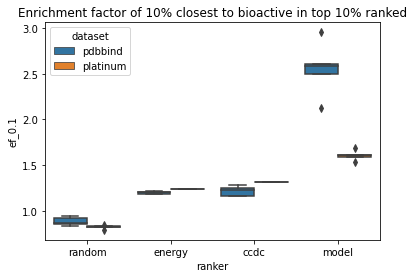

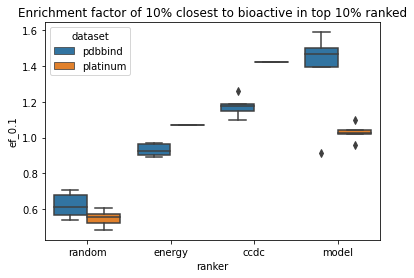

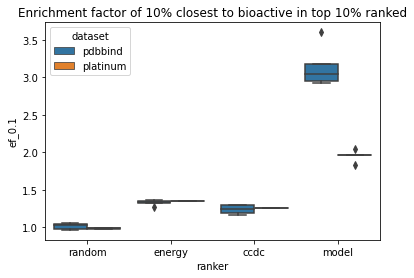

In [51]:
for subset in ['all', 'easy', 'hard'] :
    data = ranking_df[(ranking_df['split'] == 'scaffold') & (ranking_df['subset'] == subset)]
    sns.boxplot(data=data, x='ranker', y='ef_0.1', hue='dataset')
    plt.title('Enrichment factor of 10% closest to bioactive in top 10% ranked')
    plt.savefig(f'figures/ef_10_{subset}.png', dpi=200)
    plt.show()

In [52]:
data = ranking_df[(ranking_df['split'] == 'scaffold') 
                  & (ranking_df['subset'] == 'all')
                  & (ranking_df['dataset'] == 'pdbbind')
                  & (ranking_df['ranker'] == 'model')]
data

,bedroc,dataset,ef_0.1,ef_0.2,ranker,split,task,subset
3,0.348332,pdbbind,2.953835,2.340794,model,scaffold,all,all
27,0.297723,pdbbind,2.585360,2.115408,model,scaffold,all,all
51,0.290320,pdbbind,2.499197,2.105335,model,scaffold,all,all
75,0.244278,pdbbind,2.120491,1.799610,model,scaffold,all,all
99,0.297160,pdbbind,2.604819,2.176767,model,scaffold,all,all


In [53]:
print(data['ef_0.1'].mean())
print(data['ef_0.1'].std())

2.5527405120729285
0.2976405602680464


In [54]:
data = ranking_df[(ranking_df['split'] == 'scaffold') 
                  & (ranking_df['subset'] == 'all')
                  & (ranking_df['dataset'] == 'pdbbind')
                  & (ranking_df['ranker'] == 'ccdc')]
data

,bedroc,dataset,ef_0.1,ef_0.2,ranker,split,task,subset
2,0.142089,pdbbind,1.230189,1.136968,ccdc,scaffold,all,all
26,0.133880,pdbbind,1.158750,1.113063,ccdc,scaffold,all,all
50,0.139232,pdbbind,1.166578,1.132891,ccdc,scaffold,all,all
74,0.144624,pdbbind,1.251752,1.112047,ccdc,scaffold,all,all
98,0.150454,pdbbind,1.286372,1.173491,ccdc,scaffold,all,all


In [55]:
print(data['ef_0.1'].mean())
print(data['ef_0.1'].std())

1.2187281388824127
0.05503342484372345


In [56]:
data = ranking_df[(ranking_df['split'] == 'scaffold') 
                  & (ranking_df['subset'] == 'easy')
                  & (ranking_df['dataset'] == 'pdbbind')
                  & (ranking_df['ranker'] == 'model')]
print(data['ef_0.1'].mean())
print(data['ef_0.1'].std())

1.3718565145037664
0.26420347582934633


In [57]:
data = ranking_df[(ranking_df['split'] == 'scaffold') 
                  & (ranking_df['subset'] == 'easy')
                  & (ranking_df['dataset'] == 'pdbbind')
                  & (ranking_df['ranker'] == 'ccdc')]
data
print(data['ef_0.1'].mean())
print(data['ef_0.1'].std())

1.1742043855081785
0.05829878964431975


In [58]:
data = ranking_df[(ranking_df['split'] == 'scaffold') 
                  & (ranking_df['subset'] == 'hard')
                  & (ranking_df['dataset'] == 'pdbbind')
                  & (ranking_df['ranker'] == 'model')]
print(data['ef_0.1'].mean())
print(data['ef_0.1'].std())

3.1389615696486626
0.27737562838446245


In [59]:
data = ranking_df[(ranking_df['split'] == 'scaffold') 
                  & (ranking_df['subset'] == 'hard')
                  & (ranking_df['dataset'] == 'pdbbind')
                  & (ranking_df['ranker'] == 'ccdc')]
data
print(data['ef_0.1'].mean())
print(data['ef_0.1'].std())

1.2417868919320056
0.06156186871838006


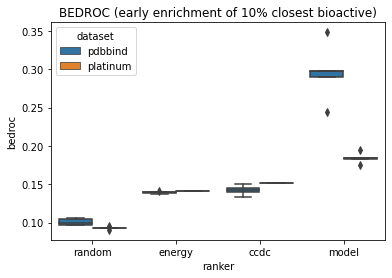

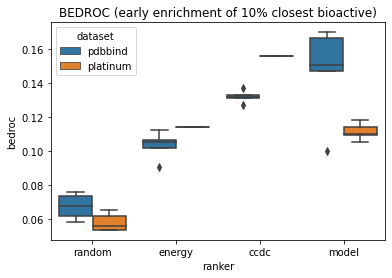

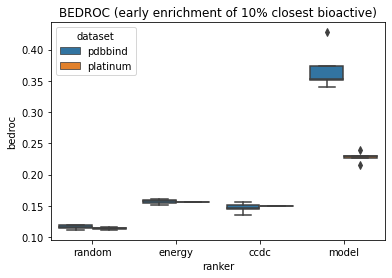

In [60]:
for subset in ['all', 'easy', 'hard'] :
    data = ranking_df[(ranking_df['split'] == 'scaffold') & (ranking_df['subset'] == subset)]
    sns.boxplot(data=data, x='ranker', y='bedroc', hue='dataset')
    plt.title('BEDROC (early enrichment of 10% closest bioactive)')
    plt.savefig(f'figures/bedroc_{subset}.png', dpi=200)
    plt.show()

In [61]:
data = ranking_df[(ranking_df['split'] == 'scaffold') 
                  & (ranking_df['subset'] == 'all')
                  & (ranking_df['dataset'] == 'pdbbind')
                  & (ranking_df['ranker'] == 'model')]
data

,bedroc,dataset,ef_0.1,ef_0.2,ranker,split,task,subset
3,0.348332,pdbbind,2.953835,2.340794,model,scaffold,all,all
27,0.297723,pdbbind,2.585360,2.115408,model,scaffold,all,all
51,0.290320,pdbbind,2.499197,2.105335,model,scaffold,all,all
75,0.244278,pdbbind,2.120491,1.799610,model,scaffold,all,all
99,0.297160,pdbbind,2.604819,2.176767,model,scaffold,all,all


In [62]:
print(data['bedroc'].mean())
print(data['bedroc'].std())

0.2955624827130414
0.03691001485014653


In [63]:
data = ranking_df[(ranking_df['split'] == 'scaffold') 
                  & (ranking_df['subset'] == 'all')
                  & (ranking_df['dataset'] == 'pdbbind')
                  & (ranking_df['ranker'] == 'ccdc')]
data

,bedroc,dataset,ef_0.1,ef_0.2,ranker,split,task,subset
2,0.142089,pdbbind,1.230189,1.136968,ccdc,scaffold,all,all
26,0.133880,pdbbind,1.158750,1.113063,ccdc,scaffold,all,all
50,0.139232,pdbbind,1.166578,1.132891,ccdc,scaffold,all,all
74,0.144624,pdbbind,1.251752,1.112047,ccdc,scaffold,all,all
98,0.150454,pdbbind,1.286372,1.173491,ccdc,scaffold,all,all


In [64]:
print(data['bedroc'].mean())
print(data['bedroc'].std())

0.14205566454529778
0.006163178128737706


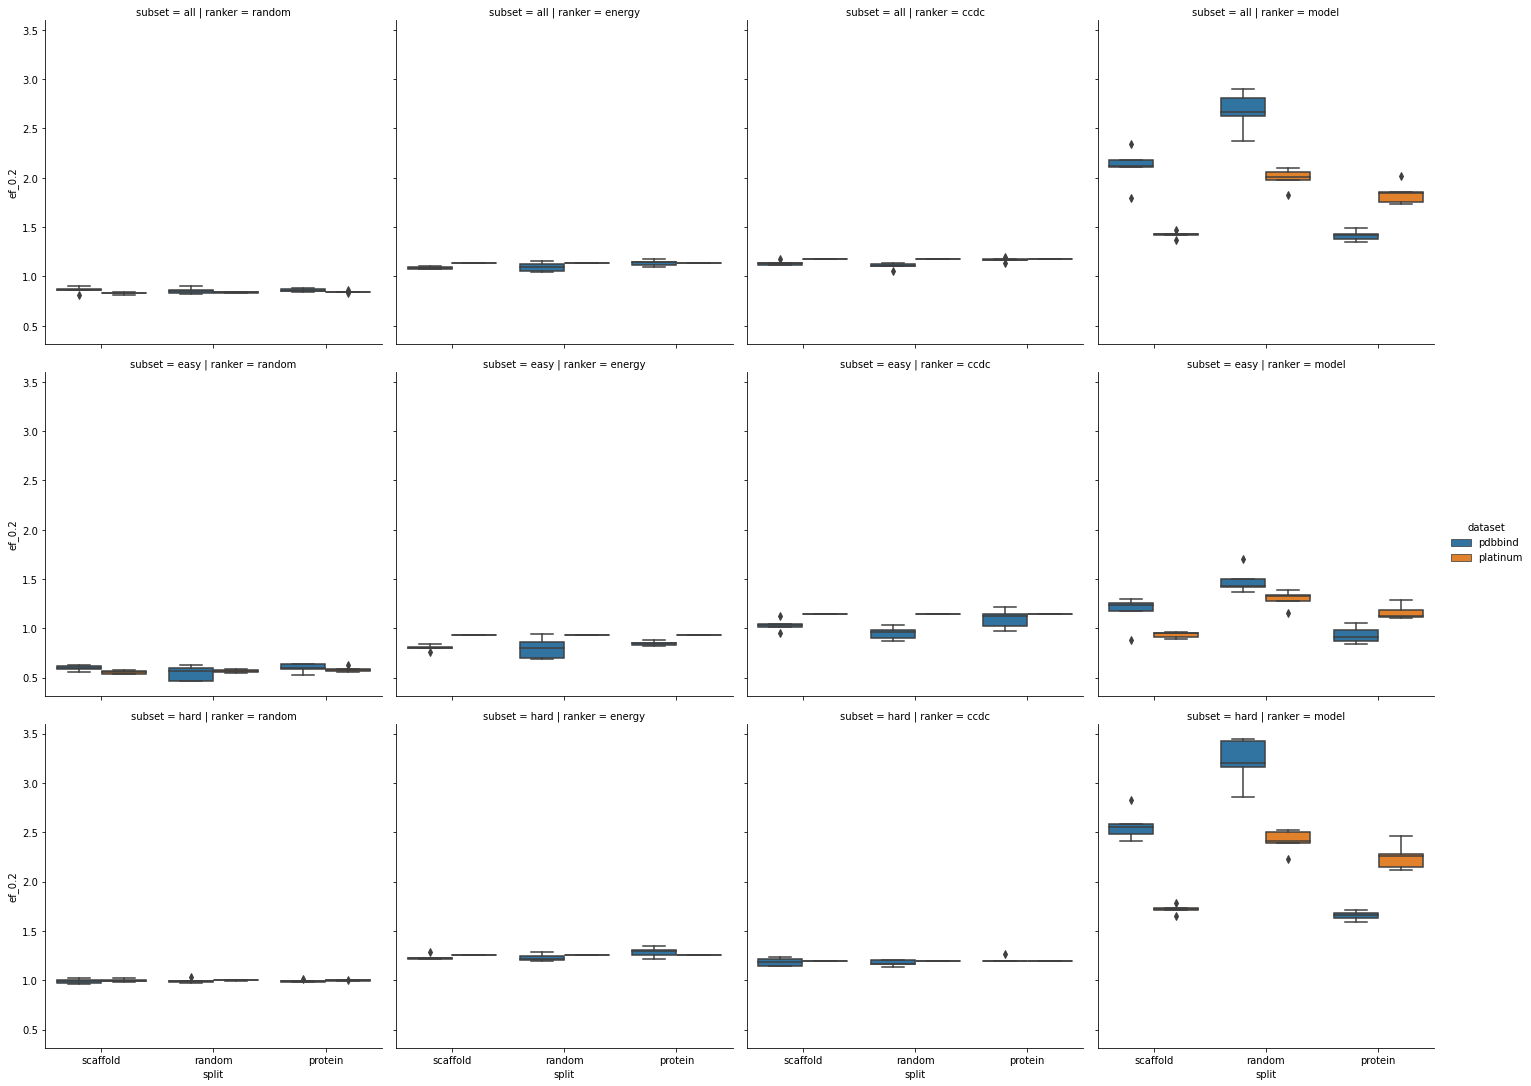

In [65]:
sns.catplot(data=ranking_df, x='split', y='ef_0.2', hue='dataset', row='subset', col='ranker', kind='box')

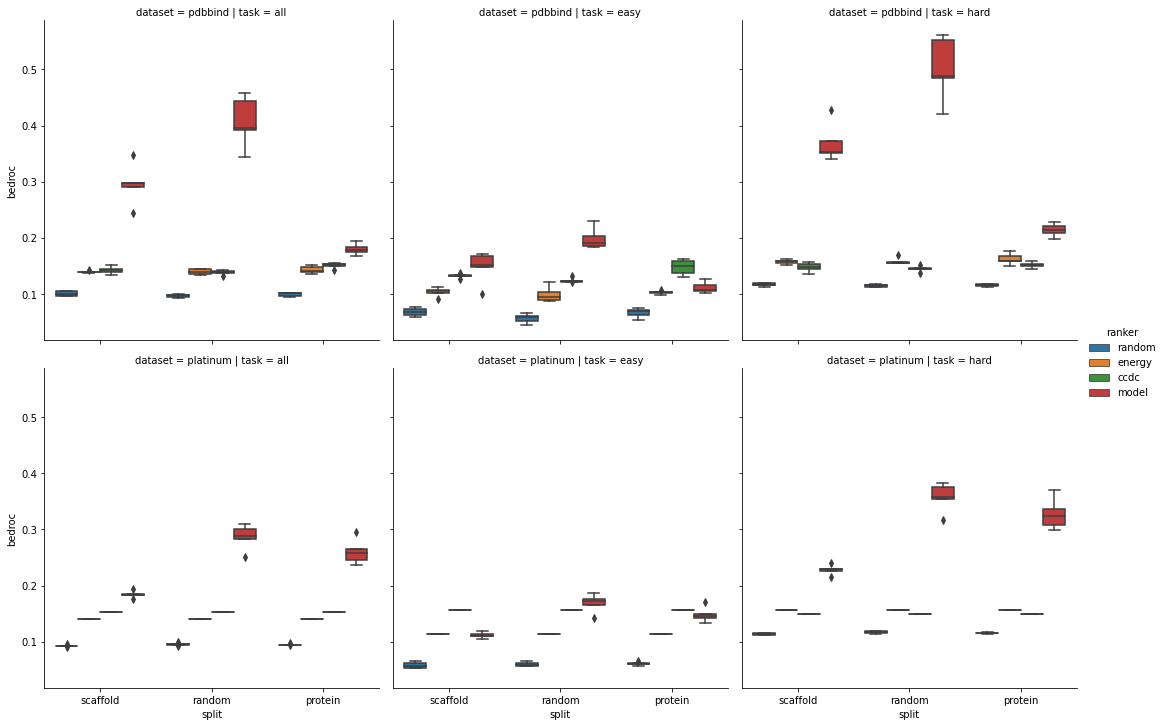

In [66]:
sns.catplot(data=ranking_df, x='split', y='bedroc', hue='ranker', row='dataset', col='task', kind='box')

In [34]:
dataset_results

{'bioactive_accuracy': {'q1_all_bioactive': 1.0,
  'median_all_bioactive': 13.0,
  'q3_all_bioactive': 45.0,
  'q1_min_bioactive': 1.0,
  'median_min_bioactive': 10.0,
  'q3_min_bioactive': 40.0,
  'mean_top1_accuracy': 0.24946996466431096,
  'mean_topN_accuracy': 0.24699141847551742,
  'split': 'random',
  'dataset': 'platinum',
  'task': 'hard'},
 'regression': {'Micro': {'rmse_all': 0.5793967,
   'rmse_gen': 0.69570005,
   'rmse_bio': 1.460689,
   'r2_all': 0.47086489565404854,
   'r2_gen': 0.19395297589302007,
   'pearson_all': 0.7002920771564061,
   'pearson_gen': 0.542203147221325,
   'spearman_all': 0.676796866106787,
   'spearman_gen': 0.5289305046209724,
   'split': 'random',
   'dataset': 'platinum',
   'task': 'hard',
   'average_type': 'Micro'},
  'Macro': {'rmse_all': 0.5403117,
   'rmse_gen': 0.5167391,
   'rmse_bio': 1.4421252,
   'r2_all': -0.3662150925498,
   'r2_gen': -0.5421303786965592,
   'pearson_all': 0.3638337258994726,
   'pearson_gen': 0.3489518002458293,
   '

In [35]:
for metric, value in dataset_results['bioactive_accuracy'].items() :
    bioactive_accuracy_df.loc[evaluation_name, metric] = value

In [36]:
bioactive_accuracy_df

,dataset,mean_top1_accuracy,mean_topN_accuracy,median_all_bioactive,median_min_bioactive,q1_all_bioactive,q1_min_bioactive,q3_all_bioactive,q3_min_bioactive,split,task,subset
0,pdbbind,0.313559,0.307604,5.0,4.0,0.0,0.0,25.0,24.0,scaffold,all,all
1,pdbbind,0.334347,0.324698,3.0,2.0,0.0,0.0,9.0,7.0,scaffold,easy,easy
2,pdbbind,0.304229,0.299932,8.0,8.0,0.0,0.0,35.0,35.0,scaffold,hard,hard
3,platinum,0.331867,0.333584,4.0,3.0,0.0,0.0,21.0,20.0,scaffold,all,all
4,platinum,0.341293,0.350690,2.0,2.0,0.0,0.0,7.0,6.0,scaffold,easy,easy
...,...,...,...,...,...,...,...,...,...,...,...,...
56,pdbbind,0.265647,0.258241,11.0,10.0,1.0,0.0,38.0,37.5,random,hard,hard
57,platinum,0.255113,0.257270,6.0,5.0,1.0,0.0,26.0,25.0,random,all,all
58,platinum,0.264415,0.274210,3.0,2.0,1.0,0.0,9.0,9.0,random,easy,easy
59,platinum,0.249470,0.246991,13.0,10.0,1.0,1.0,45.0,40.0,random,hard,hard
